In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesGeometric.nc')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, 3) # 3 means open boundary in both dimensions
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [3]:
# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e10)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [4]:
mie_mono_tables = OrderedDict()
for wavelength in sensors.get_unique_solvers():
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
size_distribution_function = at3d.size_distribution.gamma
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)


In [5]:
# We are using the ground_truth rte_grid.
dataset = rte_grid.copy(deep=True)
#dataset['density'] = solvers[.66].medium['cloud'].density
#dataset = dataset.reset_coords(['veff'], drop=True)
dataset["veff"] = solvers[.66].medium['cloud'].veff
dataset = dataset.reset_coords(['reff'], drop=True)
micro_grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, dataset
)

In [6]:
relative_scaling_reff = 1
relative_scaling_lwc = 1
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(micro_grid_to_optical_properties,
    reff=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].reff.data), relative_scaling_reff * 1.0/np.std(solvers[.66].medium['cloud'].reff.data)), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_lwc * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    )
)

In [7]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [8]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [9]:
# transform initial physical state to abstract state. 
initial_gridded_reff = carved_volume.mask.data.astype(float)*10.0
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
initial_gridded_density = carved_volume.mask.data.astype(float)*0.0
initial_1d_density = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff), 
                    state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)
                    ), axis=0)


In [10]:
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [11]:
%matplotlib inline
def plot(optimizer):
    fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
    # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
    #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
    # axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[1].plot([0,2],[0,2])
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[0].plot([10,20],[10,20])
    #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
            #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
    #axs[3].plot([0,30],[0,30])
    # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
    #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    #         uncertainty_kwargs={'add_noise': False})()
    # grads = optimizer.objective(optimizer._state)[1]
    # print(grads[27:].mean())
    # print(grads[27:].std())
    # print(grads[:9037].mean())
    # print(grads[:9037].std())
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)

In [12]:
# state_gen(x0)
# #visualize the initial state
# forward_sensors.get_measurements(solvers_reconstruct)

# for instrument in forward_sensors:
#     for im in forward_sensors.get_images(instrument):
#         py.figure()
#         im.I.T.plot()

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


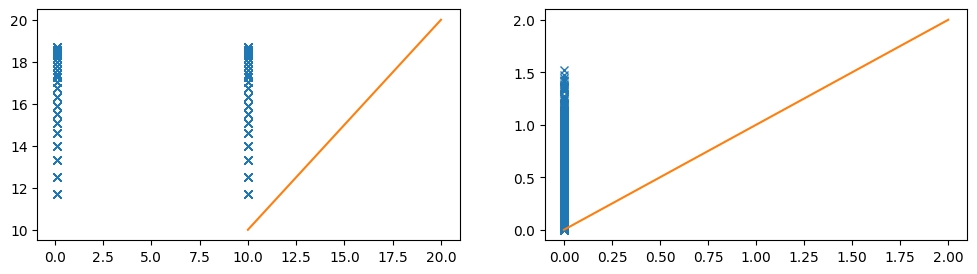

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28377     M =           10

At X0     28350 variables are exactly at the bounds

At iterate    0    f=  2.15961D+02    |proj g|=  7.63406D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.306  0.303E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -2.647  0.298E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     3  -4.375  0.298E-01    31968   228.05  0.891   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000042   [Radiance 0.660 micron]


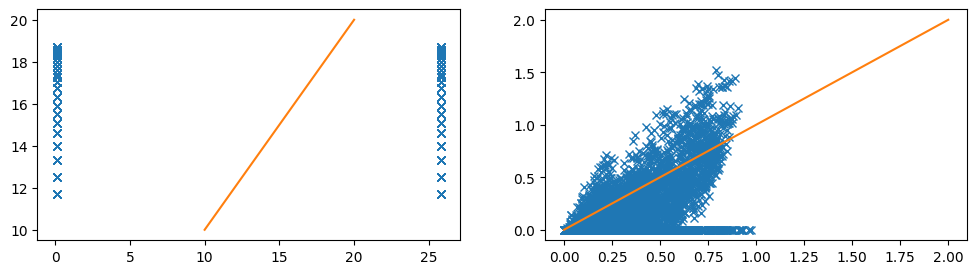

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.520  0.170E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -3.110  0.170E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     3  -5.118  0.170E-01    31968   228.05  0.891   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000008   [Radiance 0.660 micron]


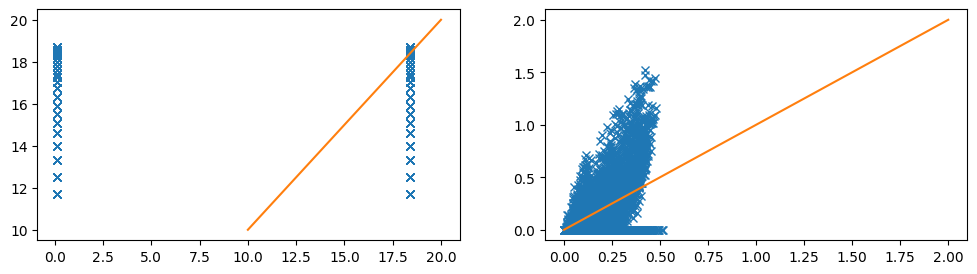

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.785  0.862E-02    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -3.689  0.862E-02    31968   228.05  0.891   [Radiance 0.660 micron]
     3  -6.025  0.862E-02    31968   228.05  0.891   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000001   [Radiance 0.660 micron]


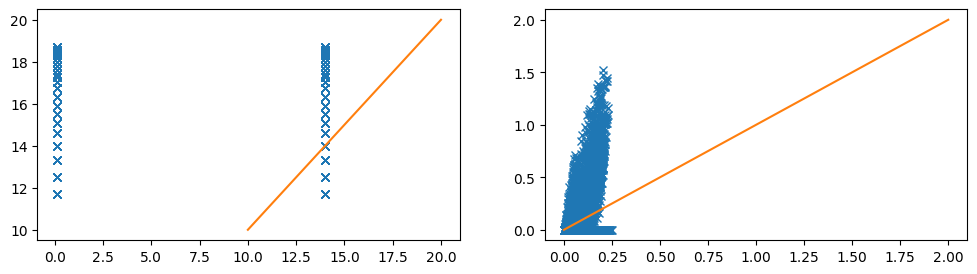


At iterate    1    f=  1.11865D+02    |proj g|=  6.17727D+00


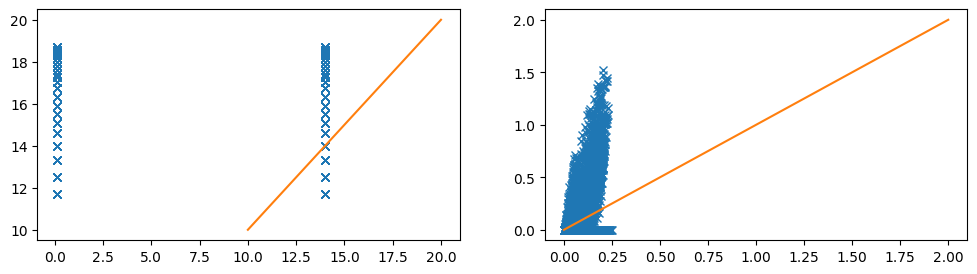

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.748  0.100E-01    31968   225.16  0.880   [Radiance 0.660 micron]
     2  -3.655  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
     3  -5.901  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000001   [Radiance 0.660 micron]


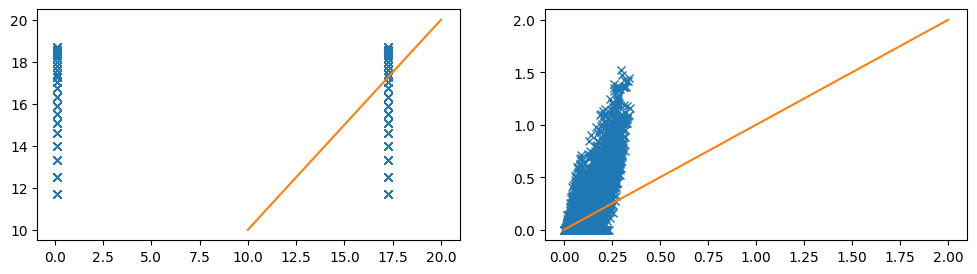


At iterate    2    f=  5.16993D+01    |proj g|=  4.96814D+00


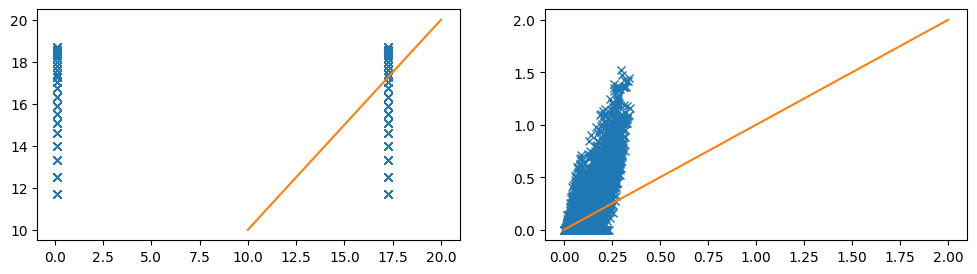

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.672  0.108E-01    31968   215.87  0.843   [Radiance 0.660 micron]
     2  -3.495  0.105E-01    31968   215.87  0.843   [Radiance 0.660 micron]
     3  -5.566  0.105E-01    31968   215.87  0.843   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]


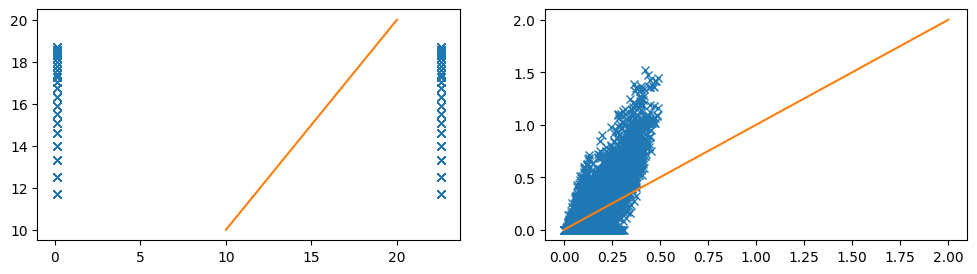


At iterate    3    f=  3.90893D+01    |proj g|=  2.89961D+00


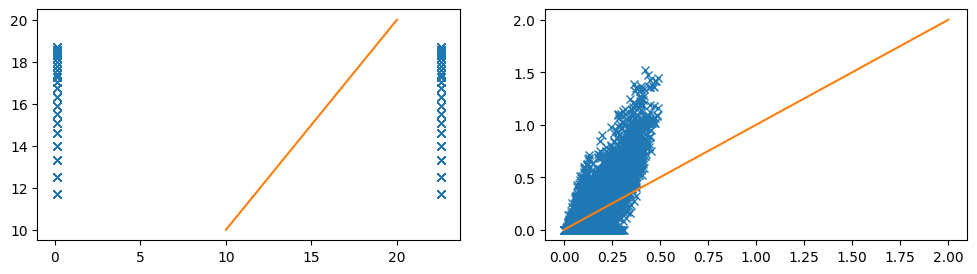

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.601  0.864E-02    31968   209.88  0.820   [Radiance 0.660 micron]
     2  -3.346  0.830E-02    31968   209.88  0.820   [Radiance 0.660 micron]
     3  -5.251  0.830E-02    31968   209.88  0.820   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000006   [Radiance 0.660 micron]


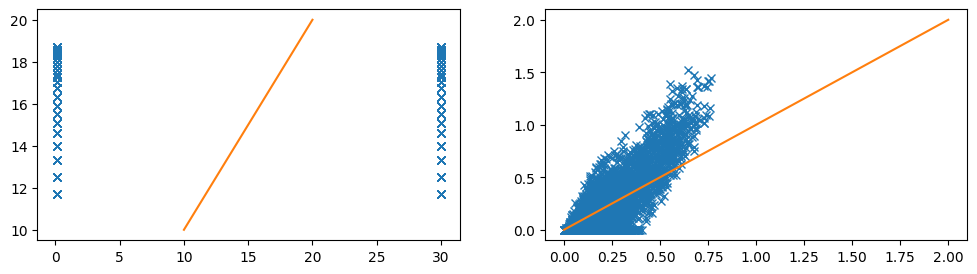


At iterate    4    f=  3.06123D+01    |proj g|=  1.05790D+00


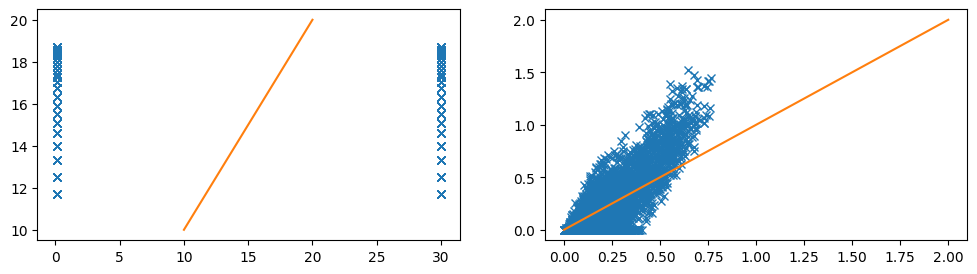

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.564  0.958E-02    31968   200.87  0.785   [Radiance 0.660 micron]
     2  -3.287  0.915E-02    31968   200.87  0.785   [Radiance 0.660 micron]
     3  -5.098  0.915E-02    31968   200.87  0.785   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000008   [Radiance 0.660 micron]


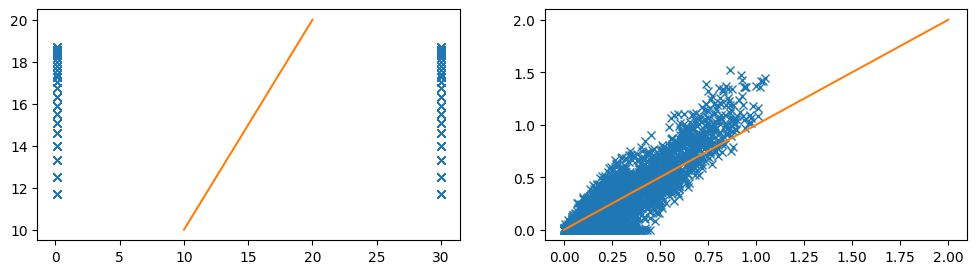


At iterate    5    f=  1.99347D+01    |proj g|=  5.74844D-01


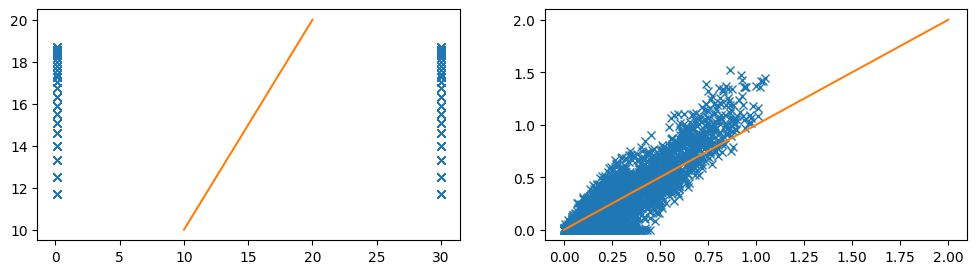

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.550  0.765E-02    31968   187.75  0.733   [Radiance 0.660 micron]
     2  -3.264  0.730E-02    31968   187.75  0.733   [Radiance 0.660 micron]
     3  -5.011  0.730E-02    31968   187.75  0.733   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


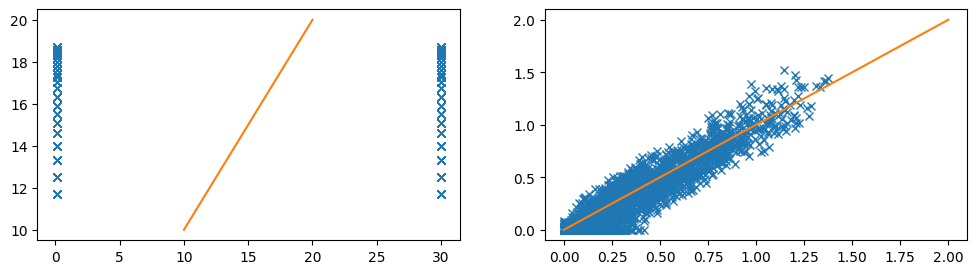


At iterate    6    f=  1.91756D+01    |proj g|=  4.14936D-01


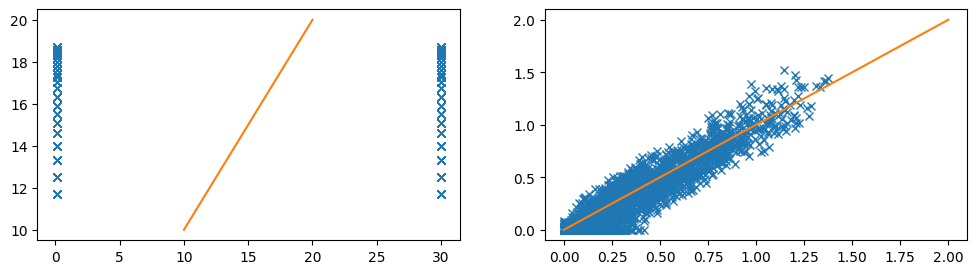

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.535  0.714E-02    31968   184.33  0.720   [Radiance 0.660 micron]
     2  -3.253  0.717E-02    31968   184.33  0.720   [Radiance 0.660 micron]
     3  -4.986  0.717E-02    31968   184.33  0.720   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


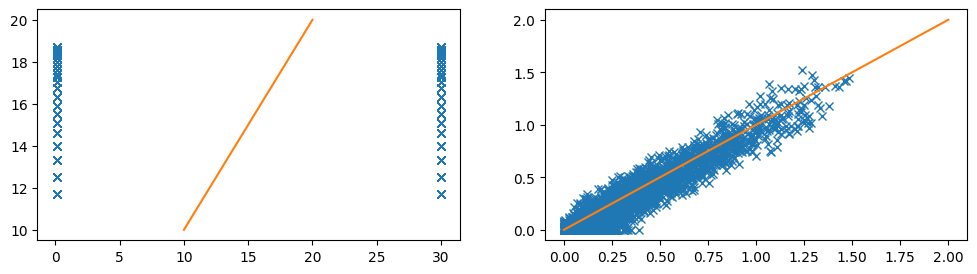


At iterate    7    f=  1.33945D+01    |proj g|=  2.72013D-01


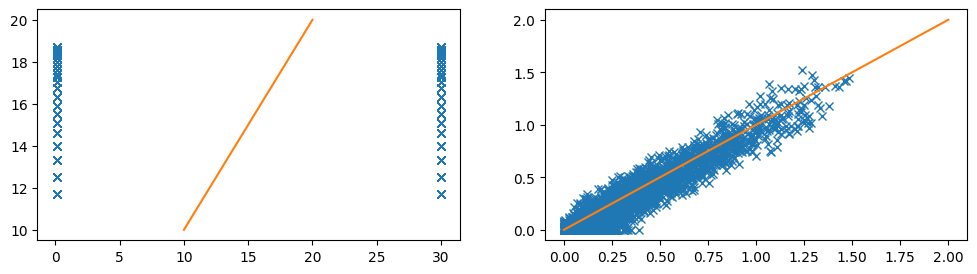

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.779E-02    31968   187.21  0.731   [Radiance 0.660 micron]
     2  -3.255  0.783E-02    31968   187.21  0.731   [Radiance 0.660 micron]
     3  -4.992  0.783E-02    31968   187.21  0.731   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


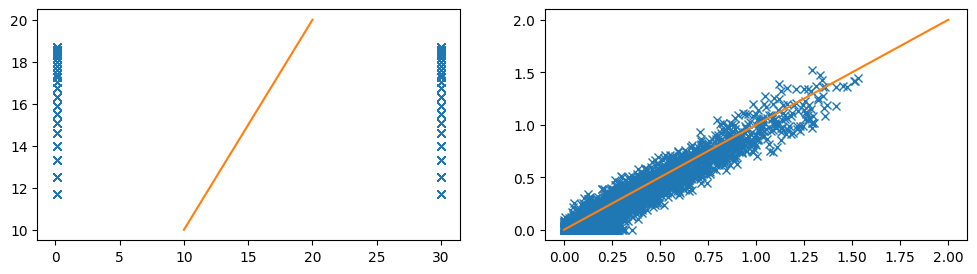


At iterate    8    f=  1.20699D+01    |proj g|=  2.50388D-01


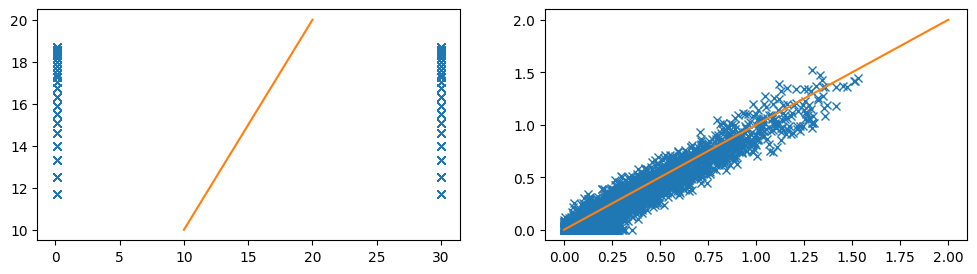

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.528  0.946E-02    31968   178.13  0.696   [Radiance 0.660 micron]
     2  -3.251  0.952E-02    31968   178.13  0.696   [Radiance 0.660 micron]
     3  -4.996  0.952E-02    31968   178.13  0.696   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


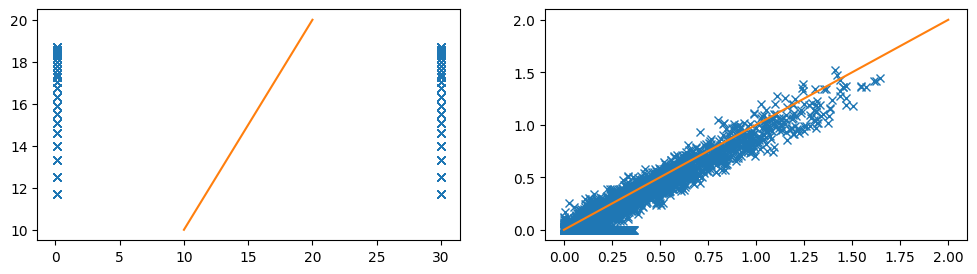

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   197.86  0.773   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   197.86  0.773   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   197.86  0.773   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


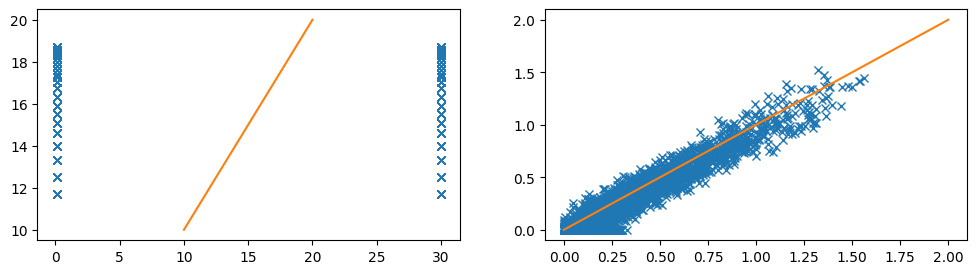


At iterate    9    f=  1.20110D+01    |proj g|=  2.70740D-01


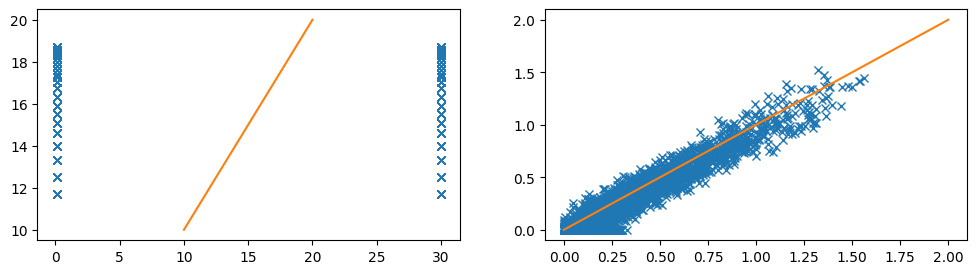

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.506  0.124E-01    31968   152.54  0.596   [Radiance 0.660 micron]
     2  -3.214  0.125E-01    31968   152.54  0.596   [Radiance 0.660 micron]
     3  -4.956  0.125E-01    31968   152.54  0.596   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000011   [Radiance 0.660 micron]


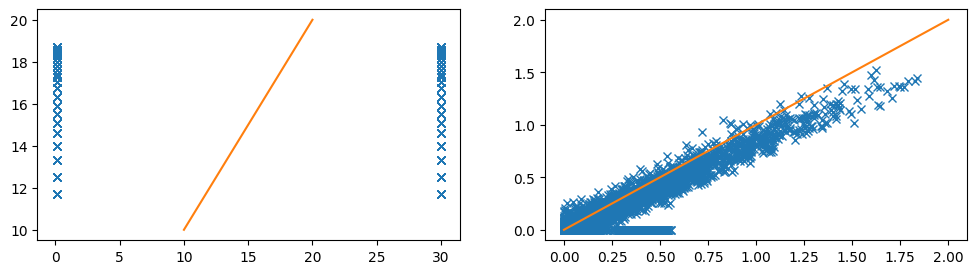

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.529  0.963E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     2  -3.245  0.969E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     3  -4.984  0.969E-02    31968   199.99  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


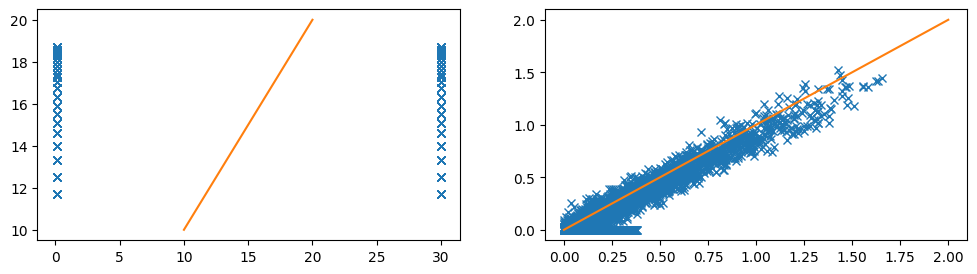

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.857E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     2  -3.253  0.862E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     3  -4.992  0.861E-02    31968   199.99  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


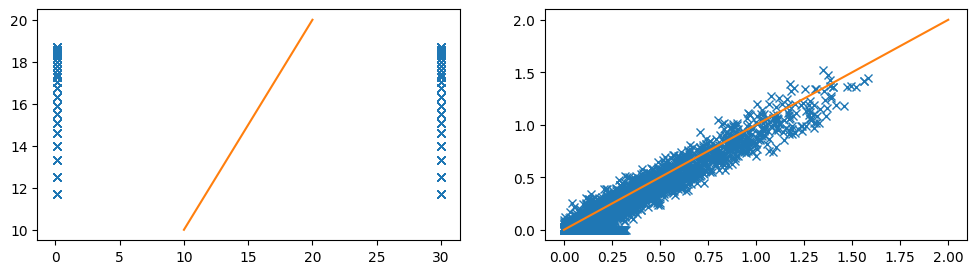

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.831E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     2  -3.255  0.835E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     3  -4.993  0.835E-02    31968   199.99  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


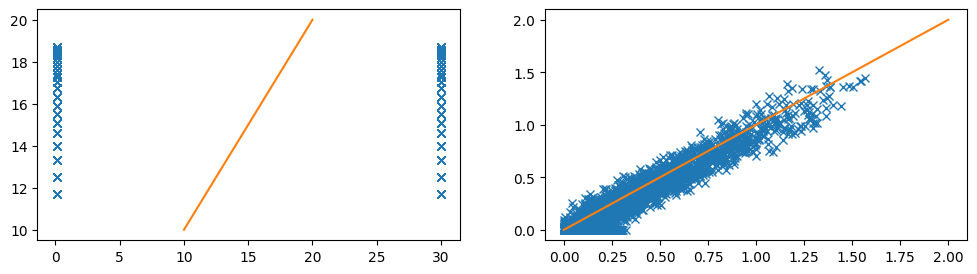

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.825E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     2  -3.255  0.829E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     3  -4.993  0.829E-02    31968   199.99  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


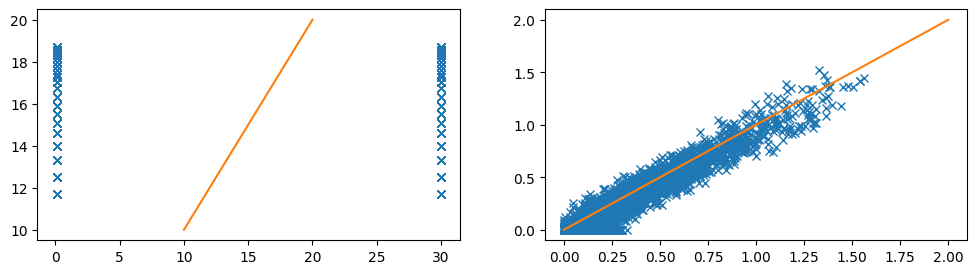

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.824E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   199.99  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


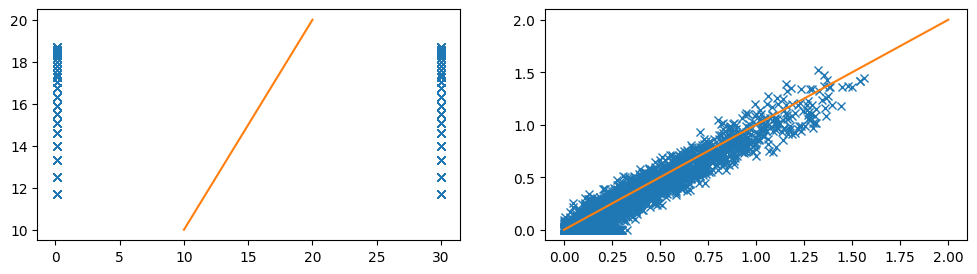

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.824E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   199.99  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


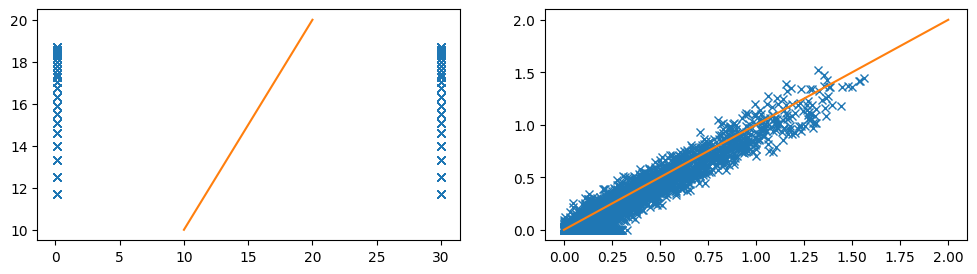

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   199.99  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


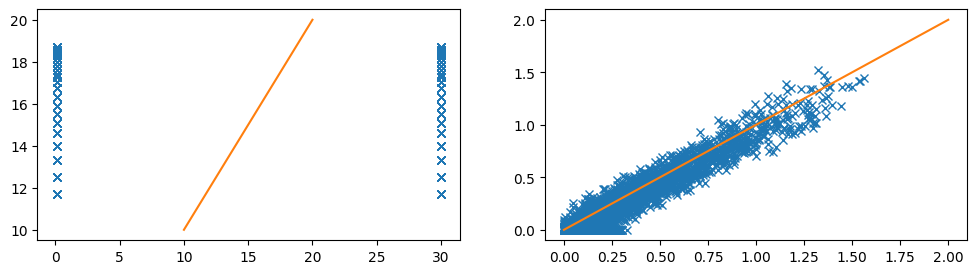

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   199.99  0.781   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   199.99  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


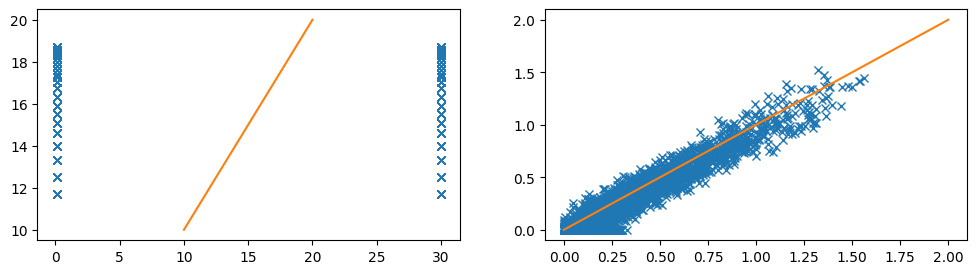

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   199.98  0.781   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   199.98  0.781   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   199.98  0.781   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


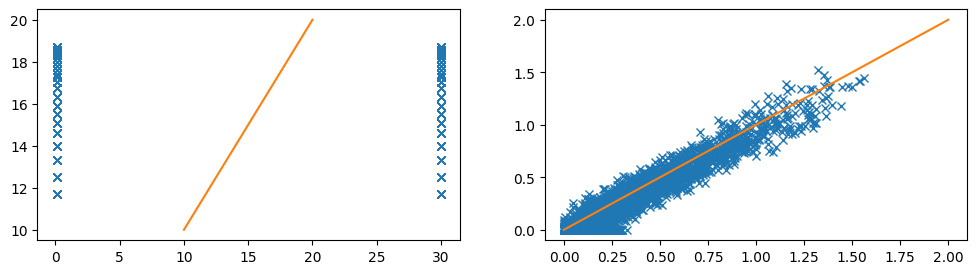


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.538  0.839E-02    31968   197.28  0.771   [Radiance 0.660 micron]
     2  -3.257  0.844E-02    31968   197.28  0.771   [Radiance 0.660 micron]
     3  -5.000  0.843E-02    31968   197.28  0.771   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


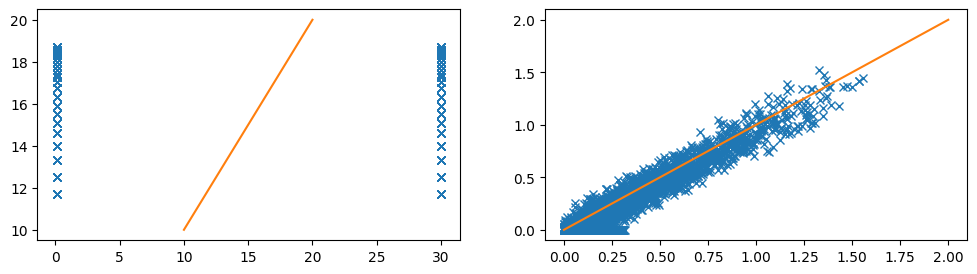

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.534  0.827E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     2  -3.256  0.832E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     3  -4.995  0.832E-02    31968   201.11  0.786   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


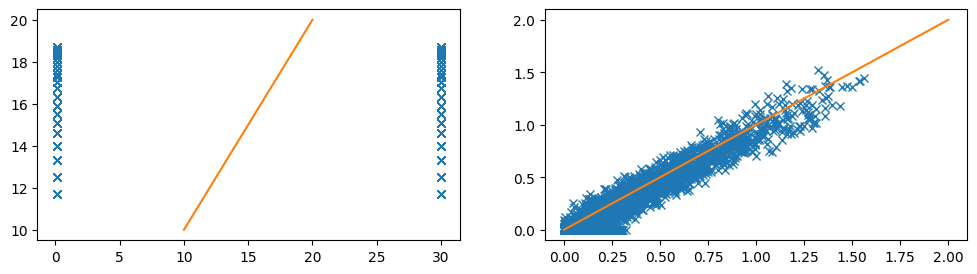

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.824E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     2  -3.255  0.829E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     3  -4.994  0.829E-02    31968   201.11  0.786   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


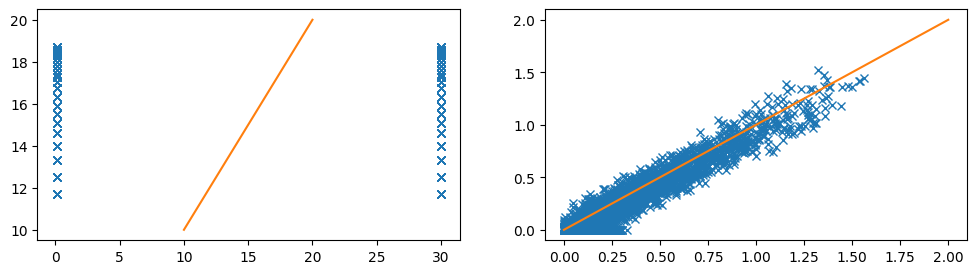

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.824E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   201.11  0.786   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


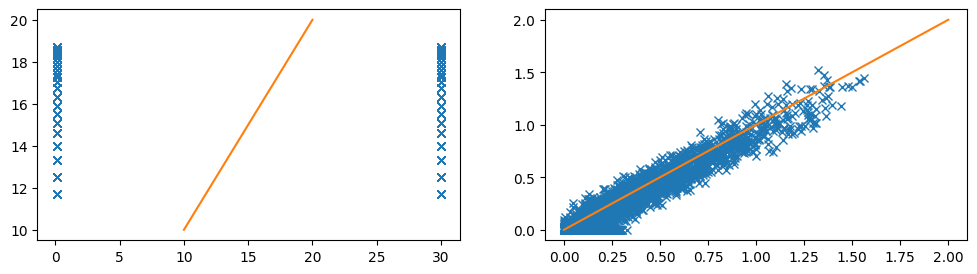

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   201.11  0.786   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


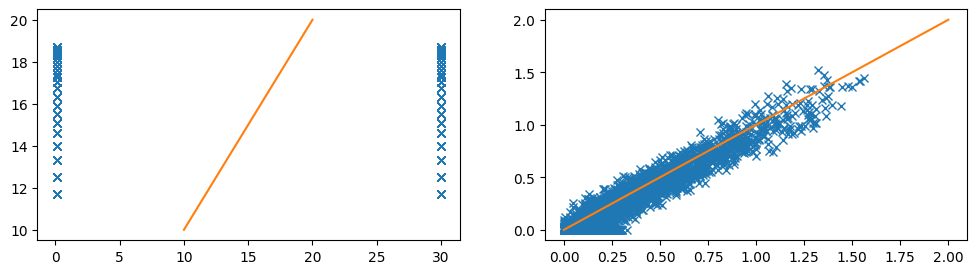

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   201.11  0.786   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


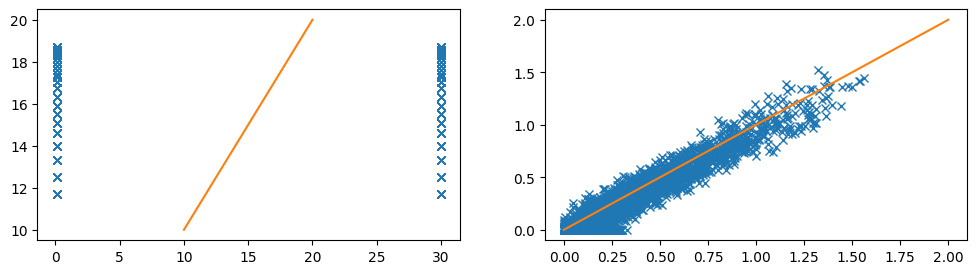

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   201.11  0.786   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   201.11  0.786   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


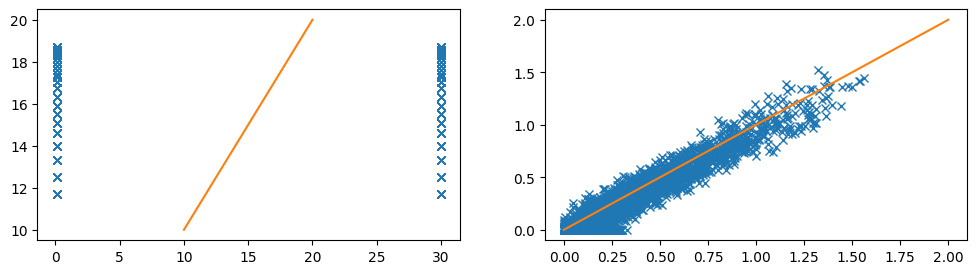

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   201.10  0.786   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   201.10  0.786   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   201.10  0.786   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


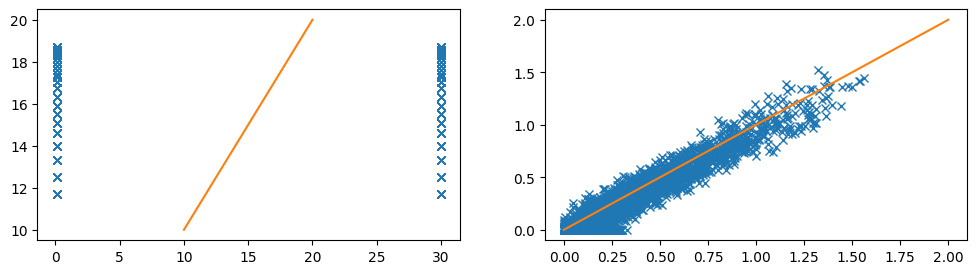

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   201.02  0.785   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   201.02  0.785   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   201.02  0.785   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


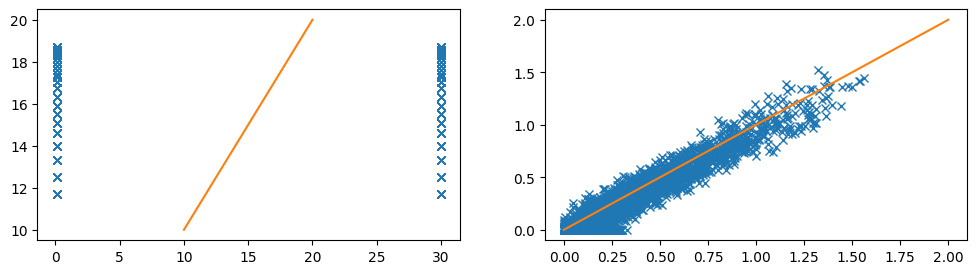

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.823E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     2  -3.255  0.828E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     3  -4.994  0.828E-02    31968   200.64  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


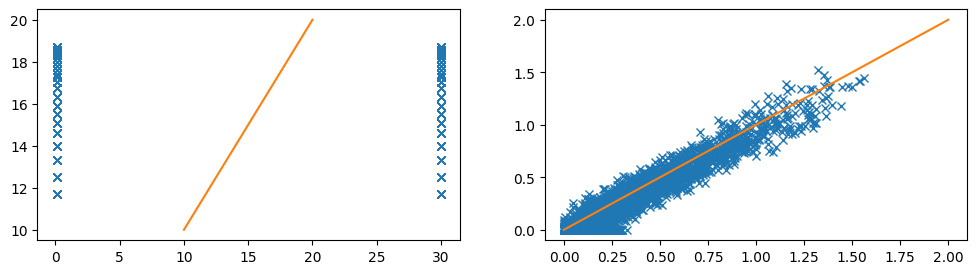


           * * *




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28377     10     33   6504     0  4009   2.707D-01   1.201D+01
  F =   12.010957215060994     

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [13]:
import warnings
optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True})
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 30
result = optimizer.minimize(x0)

In [14]:
# final_state = state_gen.get_state()
# import warnings
# warnings.filterwarnings('ignore')
# optimizer._options['maxiter'] = 30
# result = optimizer.minimize(final_state)

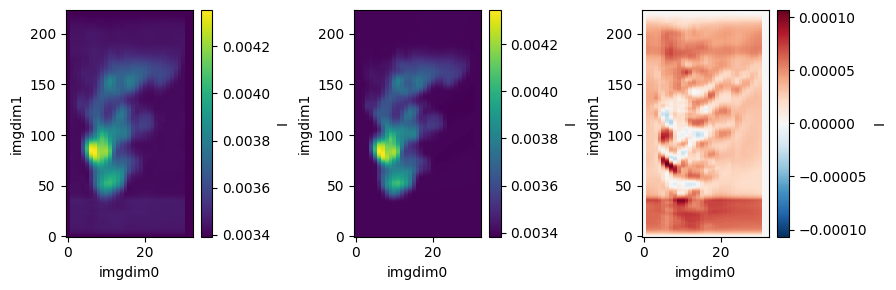

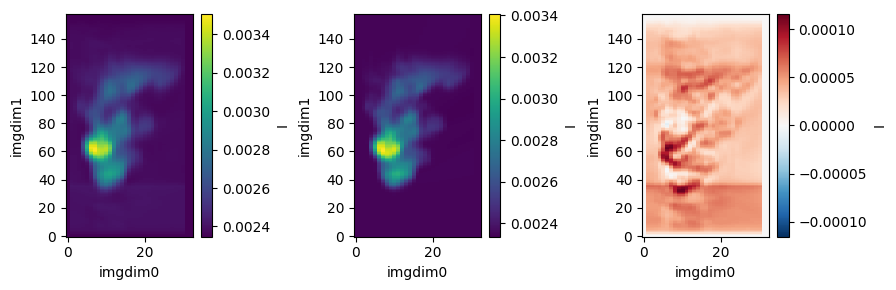

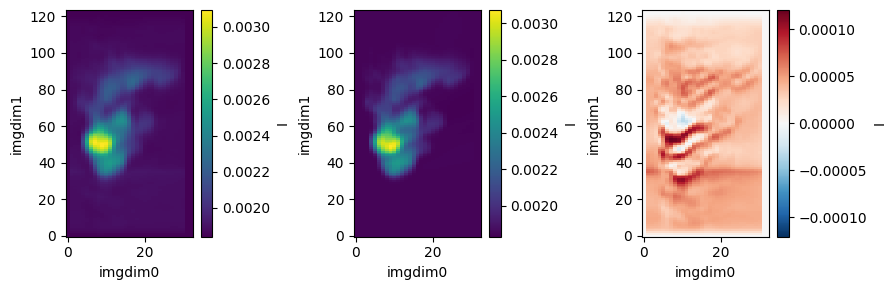

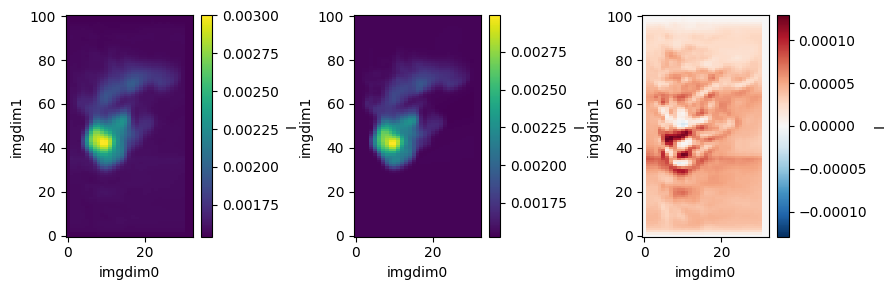

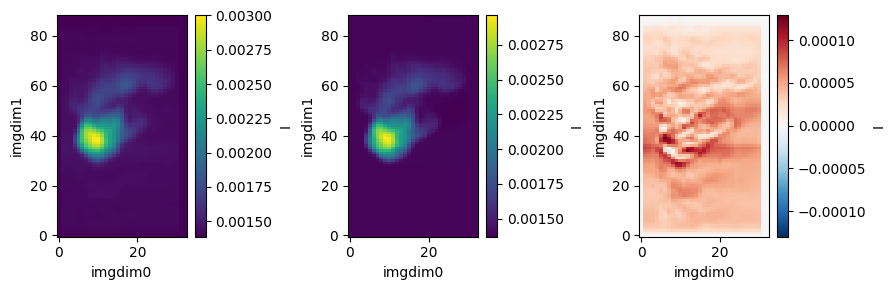

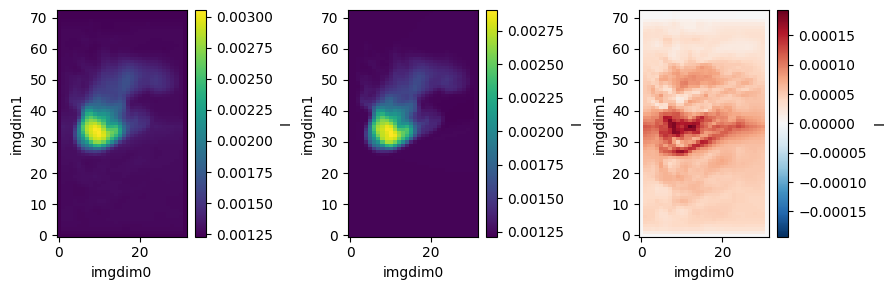

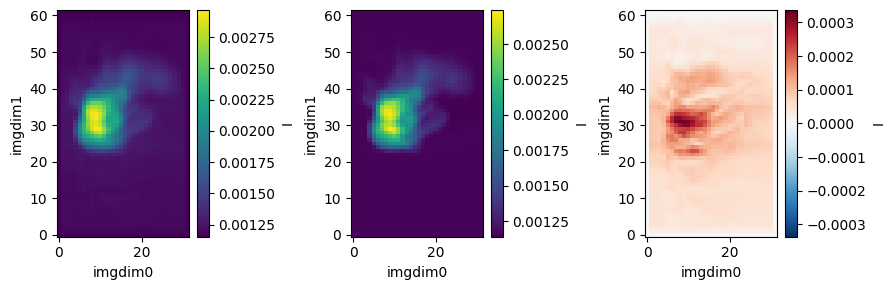

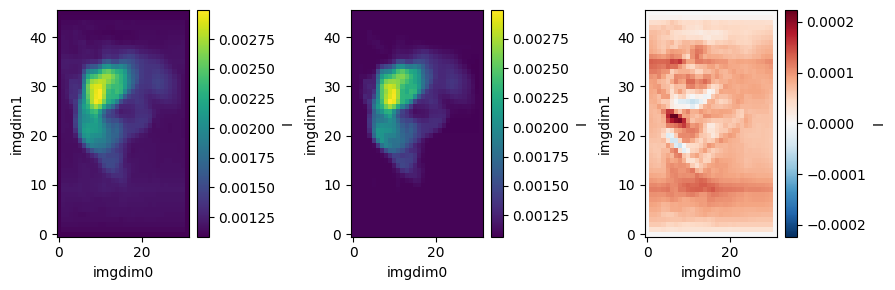

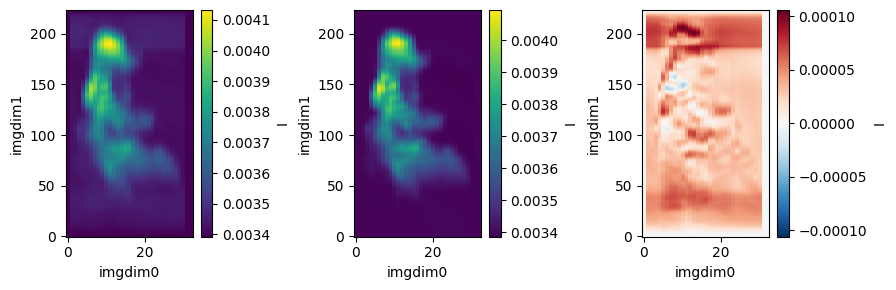

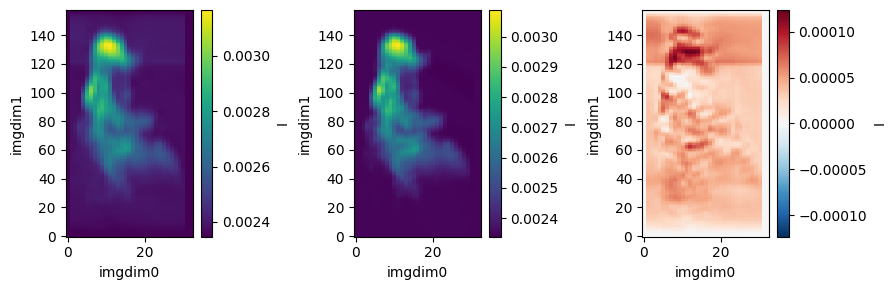

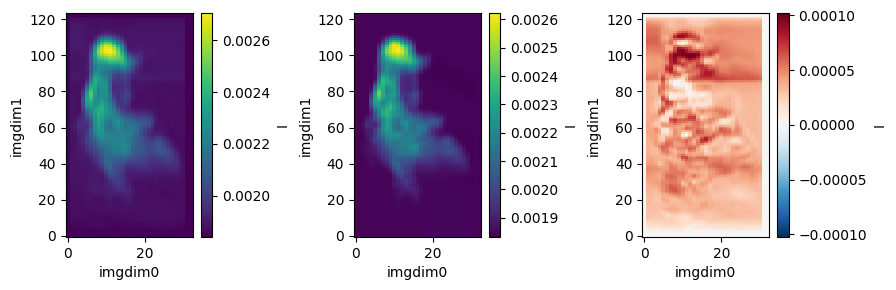

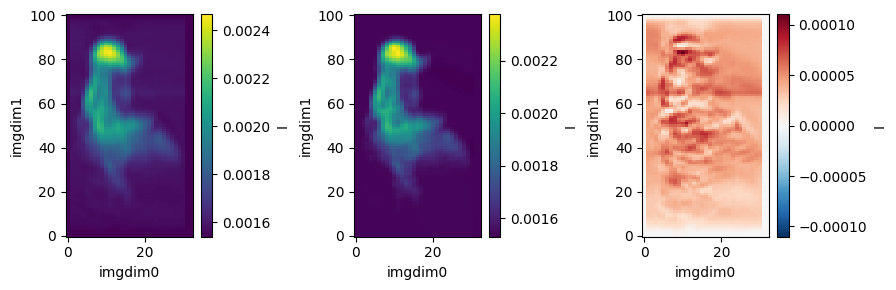

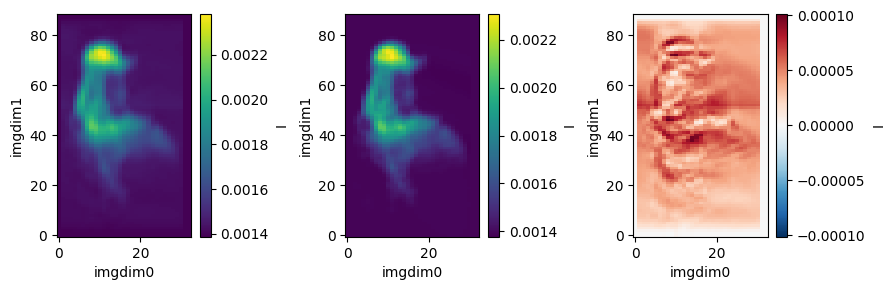

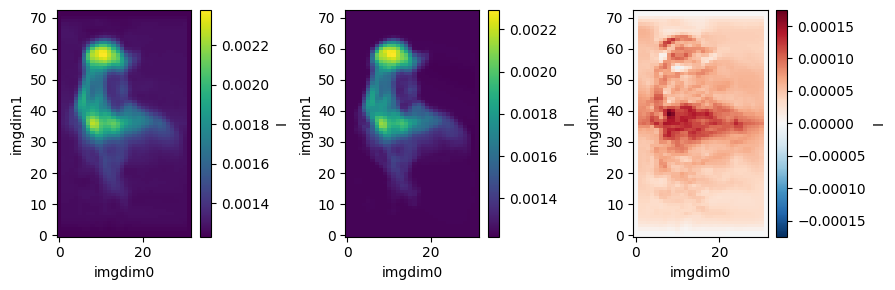

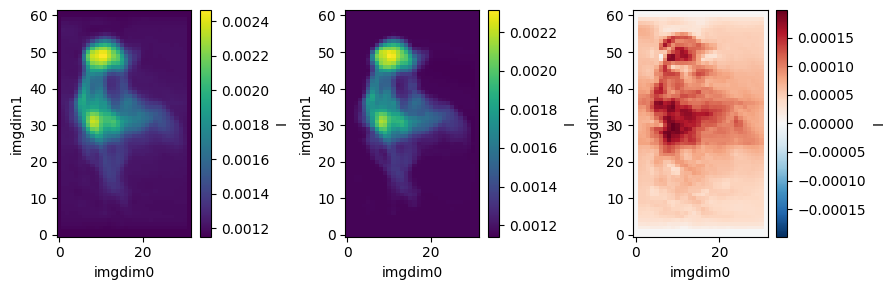

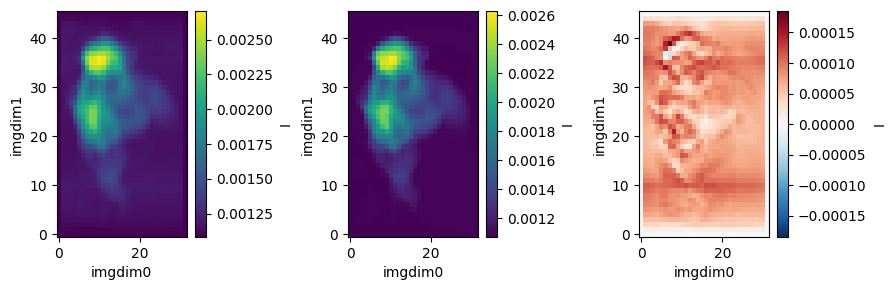

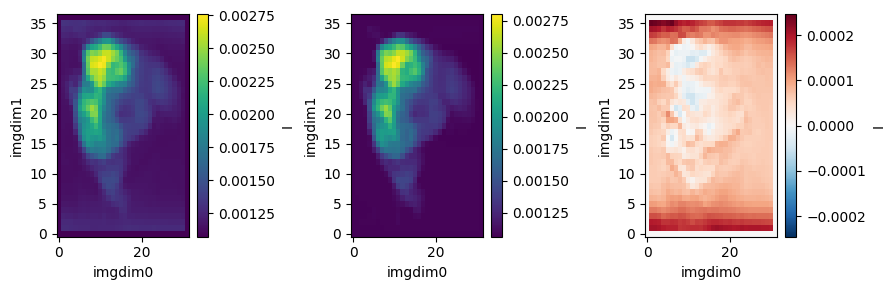

In [15]:
for instrument in forward_sensors:
    for im1,im2 in zip(forward_sensors.get_images(instrument),
                       sensors.get_images(instrument)):
        fig,ax = py.subplots(1,3, figsize=(9, 3))
        im1.I.T.plot(ax=ax[0])
        im2.I.T.plot(ax=ax[1])
        (im1.I-im2.I).T.plot(ax=ax[2])
        fig.tight_layout()

In [16]:
uncertainty_reff = at3d.uncertainties.NullUncertainty('L2',1e13) #replaces original uncertainty
sensors.add_uncertainty_model('MSPI', uncertainty_reff)

data_with_extinction = solvers_reconstruct[.66].medium['cloud'].drop_vars("reff")

micro_grid_with_extinction = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, data_with_extinction
)

In [17]:
relative_scaling_reff = 1
unknown_scatterer_reff = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(micro_grid_with_extinction,
    reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    )
)

In [18]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct_reff = at3d.containers.SolversDict()

state_gen_reff = at3d.medium.StateGenerator(solvers_reconstruct_reff,
                                         unknown_scatterer_reff, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [19]:
min_bounds_reff, max_bounds_reff = state_gen_reff.transform_bounds()
forward_sensors_reff = sensors.make_forward_sensors()

initial_gridded_reff = carved_volume.mask.data.astype(float)*10
initial_1d_reff = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
x1 = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

objective_function_reff = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct_reff, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
  state_gen_reff.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds_reff, max_bounds=max_bounds_reff)


In [20]:
def plot_reff(optimizer):
    fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
    # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
    #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
    # axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct_reff[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[1].plot([0,2],[0,2])
    axs[0].plot(solvers_reconstruct_reff[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[0].plot([10,20],[10,20])
    #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
            #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
    #axs[3].plot([0,30],[0,30])
    # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
    #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    #         uncertainty_kwargs={'add_noise': False})()
    # grads = optimizer_reff.objective(optimizer_reff._state)[1]
    # print(grads.shape)
    # print(grads.mean())
    # print(grads.std())
    py.show()
    return {'None': None}
callback_reff = at3d.callback.CallbackFn(plot_reff)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.515  0.949E-02    31968   200.65  0.784   [Radiance 0.660 micron]
     2  -3.193  0.955E-02    31968   200.65  0.784   [Radiance 0.660 micron]
     3  -4.886  0.955E-02    31968   200.65  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000013   [Radiance 0.660 micron]


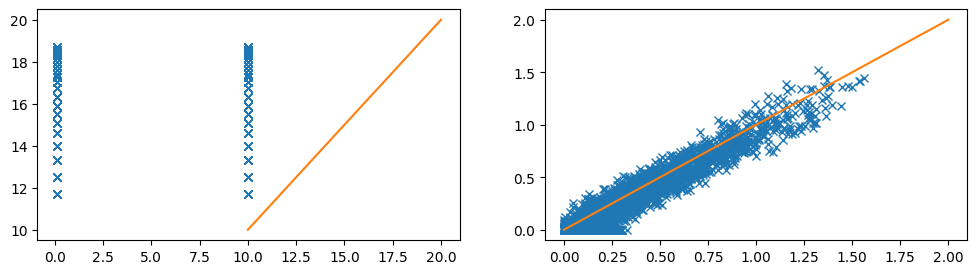

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45543D+04    |proj g|=  1.05286D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.517  0.940E-02    31968   200.65  0.784   [Radiance 0.660 micron]
     2  -3.200  0.945E-02    31968   200.65  0.784   [Radiance 0.660 micron]
     3  -4.898  0.945E-02    31968   200.65  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000013   [Radiance 0.660 micron]


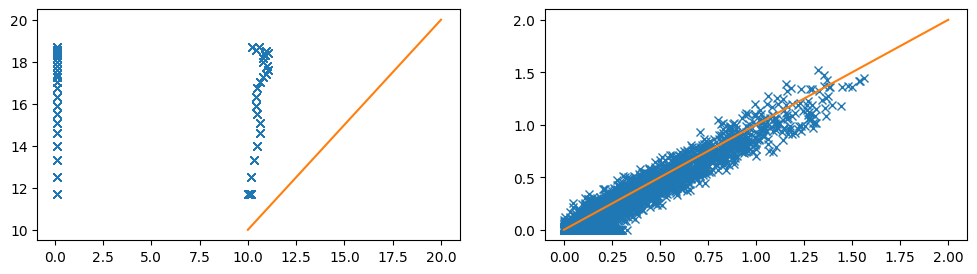


At iterate    1    f=  7.34914D+04    |proj g|=  8.33951D-01


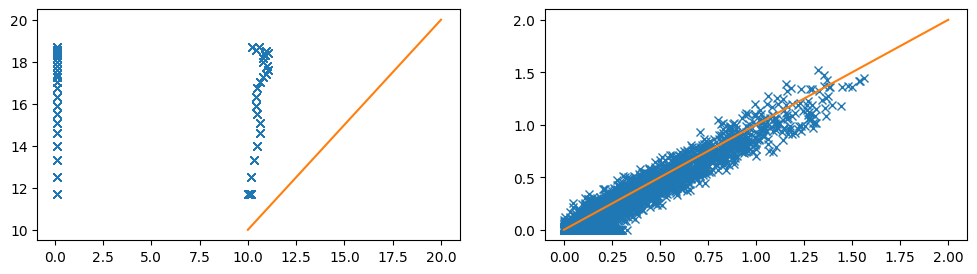

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.524  0.896E-02    31968   200.65  0.784   [Radiance 0.660 micron]
     2  -3.223  0.901E-02    31968   200.65  0.784   [Radiance 0.660 micron]
     3  -4.937  0.901E-02    31968   200.65  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000012   [Radiance 0.660 micron]


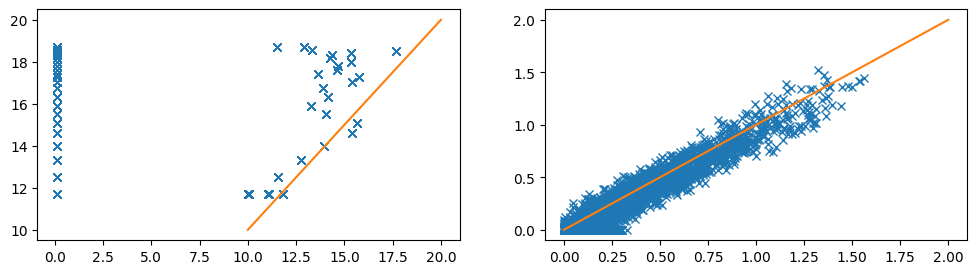


At iterate    2    f=  3.92071D+04    |proj g|=  3.43125D-01


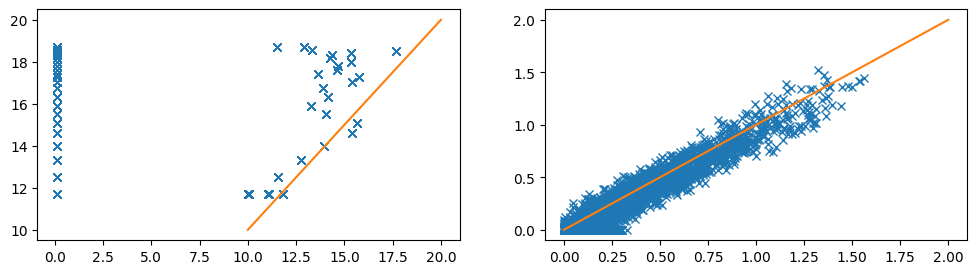

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.527  0.875E-02    31968   200.65  0.784   [Radiance 0.660 micron]
     2  -3.232  0.880E-02    31968   200.65  0.784   [Radiance 0.660 micron]
     3  -4.953  0.880E-02    31968   200.65  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000011   [Radiance 0.660 micron]


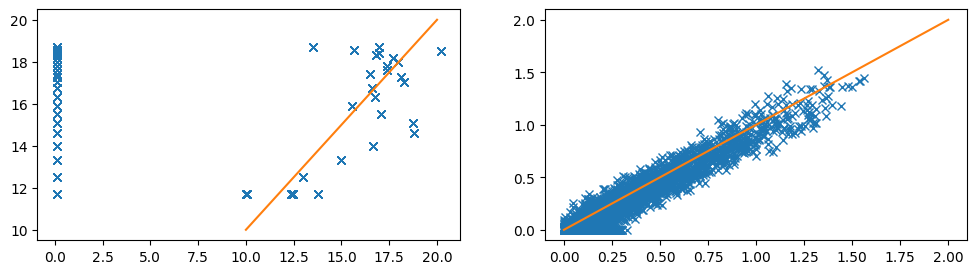


At iterate    3    f=  2.73229D+04    |proj g|=  2.14185D-01


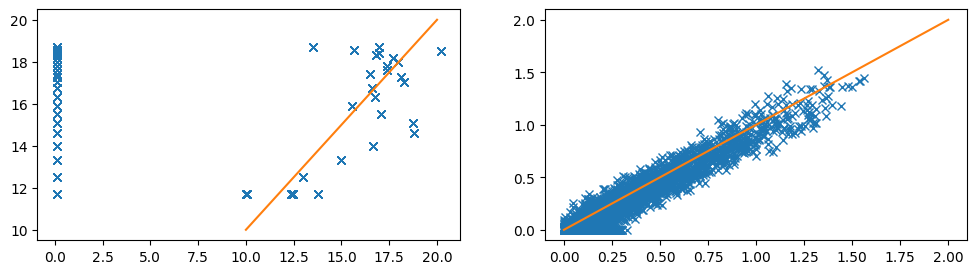

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.530  0.853E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     2  -3.241  0.858E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     3  -4.970  0.858E-02    31968   200.64  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000011   [Radiance 0.660 micron]


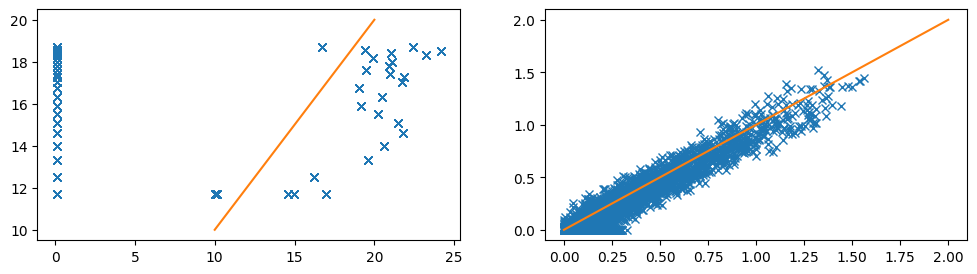


At iterate    4    f=  1.90794D+04    |proj g|=  1.00057D-01


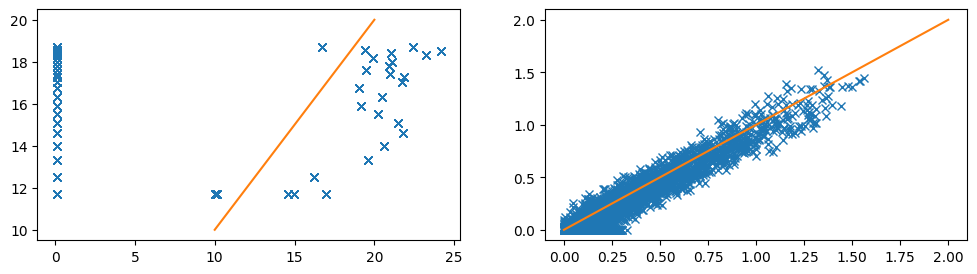

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.531  0.839E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     2  -3.248  0.843E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     3  -4.981  0.843E-02    31968   200.64  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


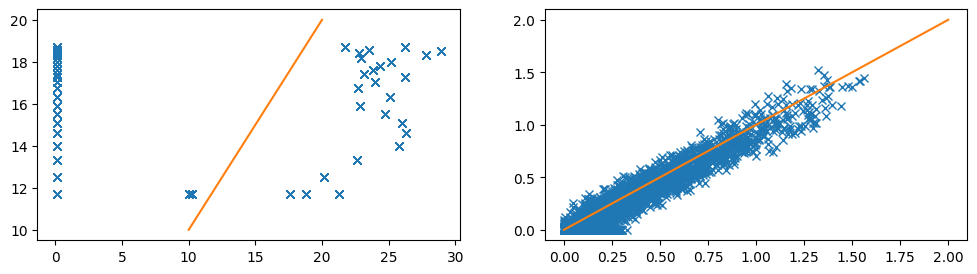


At iterate    5    f=  1.49858D+04    |proj g|=  6.80924D-02


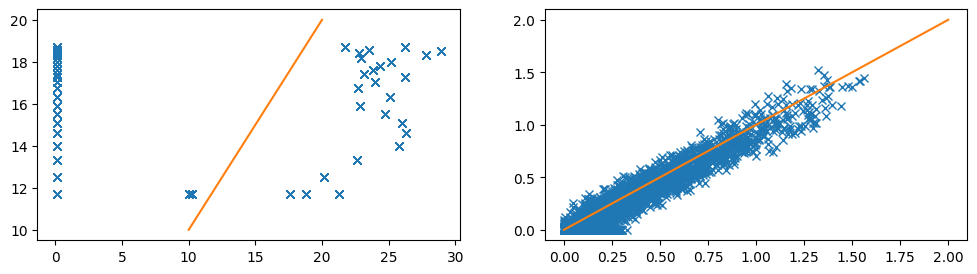

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.838E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     2  -3.253  0.842E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     3  -4.990  0.842E-02    31968   200.64  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


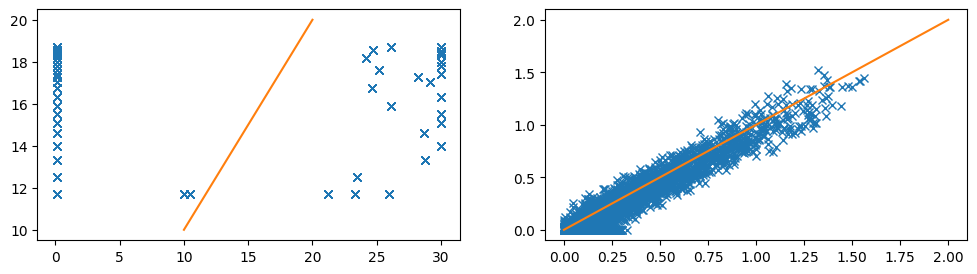


At iterate    6    f=  1.27925D+04    |proj g|=  2.31083D-02


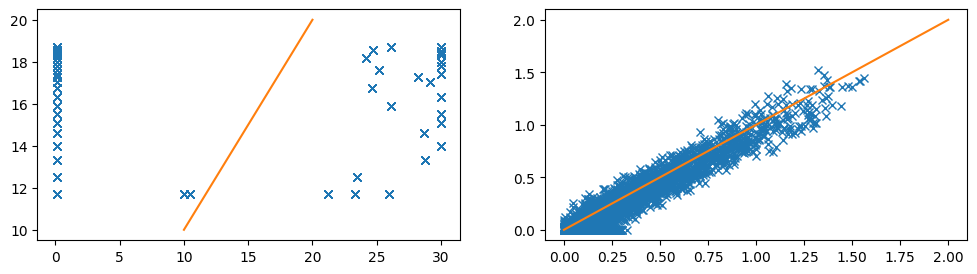

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.835E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     2  -3.254  0.840E-02    31968   200.64  0.784   [Radiance 0.660 micron]
     3  -4.992  0.840E-02    31968   200.64  0.784   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


KeyboardInterrupt: 

In [21]:
import warnings
optimizer_reff = at3d.optimize.Optimizer(objective_function_reff,callback_fn=callback_reff, options={'maxiter': 100, 'maxls': 10, 'disp': True})
warnings.filterwarnings('ignore')
optimizer_reff._options['maxiter'] = 10
result_reff = optimizer_reff.minimize(x1)

In [ ]:
# print(state_gen_reff._unknown_scatterers['cloud'].variables)
# print(unknown_scatterer_reff.items(   
# grads = optimizer_reff.objective(optimizer_reff._state)[1]
# print(grads.shape)
# print(initial_1d_reff.shape)
# gridded_grads = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid(grads)
# profiled_grads = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.gradient_transform(temp)
# print(profiled_grads)
real_grads = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform(profiled_grads)
print(real_grads)

[-6.86839385e-09 -2.04281037e-13 -1.48942514e-05 -8.72415961e-06
 -6.56236097e-06 -8.63085115e-06 -1.44679644e-05 -2.04647060e-05
 -2.37493139e-05 -2.25352544e-05 -1.75977905e-05 -1.48030351e-05
 -1.48830088e-05 -1.67161033e-05 -1.97886334e-05 -2.15316644e-05
 -2.36288927e-05 -2.37859994e-05 -1.98014325e-05 -1.70188328e-05
 -1.65701437e-05 -1.96280889e-05 -2.30095044e-05 -1.84260630e-05
 -1.18973027e-05 -8.72065461e-06 -5.20696588e-05]


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.515  0.104E-01    31968   198.24  0.774   [Radiance 0.660 micron]
     2  -3.192  0.105E-01    31968   198.24  0.774   [Radiance 0.660 micron]
     3  -4.889  0.105E-01    31968   198.24  0.774   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000013   [Radiance 0.660 micron]
nan
nan
-6176732.668814254
0.6080400042928265


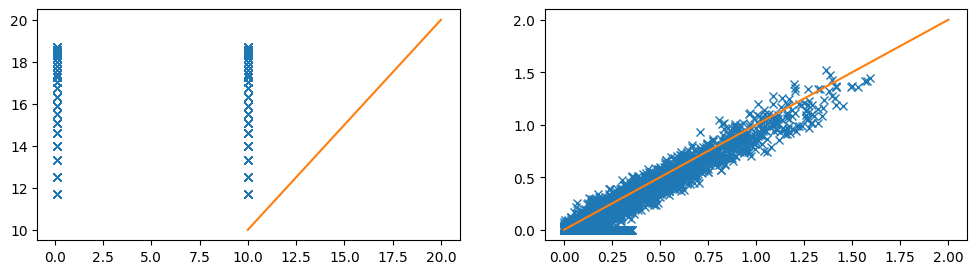

{'None': None}

In [ ]:
plot(optimizer_reff)